In [5]:
library(knitr)
library(rmdformats)
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(IRdisplay)
library(formattable)

library(xgboost)
library(tidymodels)

In [6]:
simulate_central_scenario <- function(seed = 1234){
  
  #seed = 1234  
  set.seed(seed)
  
  # Policy data
  #~~~~~~~~~~~~~~~~~
  
  # polices sold between start 2016 to end 2017
  dt_policydates <- data.table(date_UW = seq(as.Date("2016/1/1"), as.Date("2017/12/31"), "day"))
  
  # number of policies per day follows Poisson process with mean 700 (approx 255,500 pols per annum)
  dt_policydates[, ':='(policycount = rpois(.N,700),
                        date_lapse = date_UW %m+% years(1),
                        expodays = as.integer(date_UW %m+% years(1) - date_UW),
                        pol_prefix = year(date_UW)*10000 + month(date_UW)*100 + mday(date_UW))]
  
  
  # Add columns defining Policy Covers   
  dt_policydates[, Cover_B := round(policycount * 0.25)]
  dt_policydates[, Cover_BO := round(policycount * 0.45)]
  dt_policydates[, Cover_BOT := policycount - Cover_B - Cover_BO]
  
  
  # repeat rows for each policy by UW-Date
  dt_policy <- dt_policydates[rep(1:.N, policycount),c("date_UW", "pol_prefix"), with = FALSE][,pol_seq:=1:.N, by=pol_prefix]
  
  # Create a unique policy number 
  dt_policy[, pol_number := as.character(pol_prefix * 10000 + pol_seq)]
  
  # set join keys
  setkey(dt_policy,'date_UW')
  setkey(dt_policydates,'date_UW')  
  
  # remove pol_prefix before join
  dt_policydates[, pol_prefix := NULL]  
  
  # join cover from summary file (dt_policydates)
  dt_policy <- dt_policy[dt_policydates]  
  
  # now create Cover field for each policy row
  dt_policy[,Cover := 'BO']
  dt_policy[pol_seq <= policycount- Cover_BO,Cover := 'BOT']
  dt_policy[pol_seq <= Cover_B,Cover := 'B']  
  
  # remove interim calculation fields
  dt_policy[, ':='(pol_prefix = NULL,
                   policycount = NULL,
                   pol_seq = NULL,
                   Cover_B = NULL,
                   Cover_BOT = NULL,
                   Cover_BO = NULL)]
  
  # Add remaining policy details
  dt_policy[, Brand := rep(rep(c(1,2,3,4), c(9,6,3,2)), length.out = .N)]
  dt_policy[, Base_Price := rep(rep(c(600,550,300,150), c(9,6,3,2)), length.out = .N)]
  
  # models types and model cost multipliers
  for (eachBrand in unique(dt_policy$Brand)) {
    dt_policy[Brand == eachBrand, Model := rep(rep(c(3,2,1,0), c(10, 7, 2, 1)), length.out = .N)]
    dt_policy[Brand == eachBrand, Model_mult := rep(rep(c(1.15^3, 1.15^2, 1.15^1, 1.15^0), c(10, 7, 2, 1)), length.out = .N)]
  }
  
  dt_policy[, Price := ceiling (Base_Price * Model_mult)]
  
  
  # colums to keep
  cols_policy <- c("pol_number",
                   "date_UW",
                   "date_lapse",
                   "Cover",
                   "Brand",
                   "Model",
                   "Price")
  
  dt_policy <- dt_policy[, cols_policy, with = FALSE]
  
  # check output
  head(dt_policy)
  
  #save(dt_policy, file = "./dt_policy.rda")
  
  
  # Claims data
  #~~~~~~~~~~~~~~~~~
  
 # All policies have breakage cover
  # claims uniformly sampled from policies
  claim <- sample(nrow(dt_policy), size = floor(nrow(dt_policy) * 0.15))
  
  # Claim serverity multiplier sampled from beta distn
  dt_claim <- data.table(pol_number = dt_policy[claim, pol_number],
                         claim_type = 'B',
                         claim_count = 1,
                         claim_sev = rbeta(length(claim), 2,5))
  
  # identify all policies with Oxidation cover
  cov <- which(dt_policy$Cover != 'B')
  
  # sample claims from policies with cover
  claim <- sample(cov, size = floor(length(cov) * 0.05))
  
  # add claims to table 
  dt_claim <- rbind(dt_claim,
                    data.table(pol_number = dt_policy[claim, pol_number],
                               claim_type = 'O',
                               claim_count = 1,
                               claim_sev = rbeta(length(claim), 5,3)))
  
  
  # identify all policies with Theft cover
  # for Theft claim frequency varies by Brand
  # So need to consider each in turn...
  
  for(myModel in 0:3) {
    
    cov <- which(dt_policy$Cover == 'BOT' & dt_policy$Model == myModel)
    claim <- sample(cov, size = floor(length(cov) * 0.05*(1 + myModel)))
    
    dt_claim <- rbind(dt_claim,
                      data.table(pol_number = dt_policy[claim, pol_number],
                                 claim_type = 'T',
                                 claim_count = 1,
                                 claim_sev = rbeta(length(claim), 5,.5)))
  }
  
  # set join keys
  setkey(dt_policy, pol_number)
  setkey(dt_claim, pol_number)
  
  #join Brand and Price from policy to claim
  dt_claim[dt_policy,
           on = 'pol_number',
           ':='(date_UW = i.date_UW,
                Price = i.Price,
                Brand = i.Brand)]
  
  # use lubridate %m+% date addition operator 
  dt_claim[, date_lapse := date_UW %m+% years(1)]
  dt_claim[, expodays := as.integer(date_lapse - date_UW)]
  dt_claim[, occ_delay_days := floor(expodays * runif(.N, 0,1))]
  
  dt_claim[ ,delay_report := floor(365 * rbeta(.N, .4, 10))]  
  dt_claim[ ,delay_pay := floor(10 + 40* rbeta(.N, 7,7))]  
  
  dt_claim[, date_occur := date_UW %m+% days(occ_delay_days)]
  dt_claim[, date_report := date_occur %m+% days(delay_report)]
  dt_claim[, date_pay := date_report %m+% days(delay_pay)]
  
  dt_claim[, claim_cost := round(Price * claim_sev)]
  
  dt_claim[, clm_prefix := year(date_report)*10000 + month(date_report)*100 + mday(date_report)]
  
  dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
  dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]
  
  # colums to keep
  cols_claim <- c("clm_number",
                  "pol_number",
                  "claim_type",
                  "claim_count",
                  "claim_sev",
                  "date_occur",
                  "date_report",
                  "date_pay",
                  "claim_cost")
  
  dt_claim <- dt_claim[, cols_claim, with = FALSE]
  
 output <- list()
 output$dt_policy <- dt_policy
 output$dt_claim <- dt_claim

 return(output)

  
  
}

In [7]:
dt_PhoneData <- simulate_central_scenario(1234)

In [8]:
dt_policy <- dt_PhoneData$dt_policy

In [9]:
head(dt_policy)

pol_number,date_UW,date_lapse,Cover,Brand,Model,Price
<chr>,<date>,<date>,<chr>,<dbl>,<dbl>,<dbl>
201601010001,2016-01-01,2017-01-01,B,1,3,913
201601010002,2016-01-01,2017-01-01,B,1,3,913
201601010003,2016-01-01,2017-01-01,B,1,3,913
201601010004,2016-01-01,2017-01-01,B,1,3,913
201601010005,2016-01-01,2017-01-01,B,1,3,913
201601010006,2016-01-01,2017-01-01,B,1,3,913


In [10]:
dt_claim <- dt_PhoneData$dt_claim

kable(head(dt_claim), "html") %>% 
  kable_styling(c("striped", "hover", "condensed")) %>% 
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606080001,201601010001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305
201609150001,201601010014,B,1,0.3692034,2016-09-15,2016-09-15,2016-10-17,309
201609090001,201601010025,B,1,0.4496012,2016-09-09,2016-09-09,2016-10-07,357
201602190001,201601010027,B,1,0.4019731,2016-01-25,2016-02-19,2016-03-21,319
201605140001,201601010043,B,1,0.2146653,2016-05-14,2016-05-14,2016-06-15,196
201612110001,201601010045,B,1,0.2783313,2016-12-11,2016-12-11,2017-01-06,254


In [11]:
# add a unique claimkey based upon occurence date

dt_claim[, clm_prefix := year(date_occur)*10000 + month(date_occur)*100 + mday(date_occur)]
dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]


# keep only first claim against policy (competing hazards)
setkeyv(dt_claim, c("pol_number", "clm_prefix"))
dt_claim[, polclm_seq := seq_len(.N), by = .(pol_number)]
dt_claim <- dt_claim[polclm_seq == 1,]

# colums to keep
cols_claim <- c("clm_number",
                "pol_number",
                "claim_type",
                "claim_count",
                "claim_sev",
                "date_occur",
                "date_report",
                "date_pay",
                "claim_cost")

dt_claim <- dt_claim[, cols_claim, with = FALSE]

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606080001,201601010001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305
201609150001,201601010014,B,1,0.3692034,2016-09-15,2016-09-15,2016-10-17,309
201609090001,201601010025,B,1,0.4496012,2016-09-09,2016-09-09,2016-10-07,357
201601250001,201601010027,B,1,0.4019731,2016-01-25,2016-02-19,2016-03-21,319
201605140001,201601010043,B,1,0.2146653,2016-05-14,2016-05-14,2016-06-15,196
201612110001,201601010045,B,1,0.2783313,2016-12-11,2016-12-11,2017-01-06,254


In [12]:
setnames(dt_policy, c('date_UW', 'date_lapse'), c('date_pol_start', 'date_pol_end'))
  
# set policy start and end dates in foverlap friendly format
dt_policy[, date_pol_start:= floor_date(date_pol_start, unit= "second")]
dt_policy[, date_pol_end:= floor_date(date_pol_end, unit= "second") - 1]
  
# create a dummy end claim occurrence date for foverlap
dt_claim[, date_occur:= floor_date(date_occur, unit= "second")]
dt_claim[, date_occur_end:= date_occur]
dt_claim[, date_report:= floor_date(date_report, unit= "second")]
dt_claim[, date_pay:= floor_date(date_pay, unit= "second")]
  
# set keys for claim join (by policy and dates)
setkey(dt_claim, pol_number, date_occur, date_occur_end)
setkey(dt_policy, pol_number, date_pol_start, date_pol_end)
  
# use foverlaps to attach claim to right occurrence period and policy
dt_polclaim <- foverlaps(dt_policy, dt_claim, type="any") ## return overlap indices
dt_polclaim[, date_occur_end := NULL]

In [13]:
head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,date_pol_end,Cover,Brand,Model,Price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
201601010001,201606080001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010002,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010003,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010004,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010005,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010006,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913


In [14]:
setkey(dt_polclaim, pol_number, date_pol_start)
  
# create 2 new cols that count how many claims against each policy
dt_polclaim[,
            ':='(pol_seq = seq_len(.N),
                 pol_seq_max = .N),
            by = c('pol_number', 'date_pol_start') ]
  
table(dt_polclaim[, pol_seq_max])


     1 
512246 

In [15]:
#set NA dates to 31/12/2999
lst_datefields <- grep(names(dt_polclaim),pattern = "date", value = TRUE)
  
for (datefield in lst_datefields)
  set(dt_polclaim,which(is.na(dt_polclaim[[datefield]])),datefield,as_datetime("2199-12-31 23:59:59 UTC"))
 
#set other NAs to zero (claim counts and costs)
for (field in c("claim_count", "claim_sev", "claim_cost"))
  set(dt_polclaim,which(is.na(dt_polclaim[[field]])),field,0)


In [16]:

#Clean up ----
dt_polclaim[, ExpoDays:= ceiling((as.numeric(date_pol_end) - as.numeric(date_pol_start))/(24*60*60*365))]
dt_polclaim <- dt_polclaim[ExpoDays > 0]
  
rm(dt_claim)
rm(dt_policy)
  
gc()

     

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2929319,156.5,6480111,346.1,6394191,341.5
Vcells,18991644,144.9,40956144,312.5,33966974,259.2


In [17]:
head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,date_pol_end,Cover,Brand,Model,Price,pol_seq,pol_seq_max,ExpoDays
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
201601010001,201606080001,B,1,0.3337923,2016-06-08 00:00:00,2016-06-08 00:00:00,2016-07-21 00:00:00,305,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010002,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010003,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010004,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010005,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010006,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2


In [18]:

lst_Date_slice <- floor_date(seq(as.Date("2016/1/1"), as.Date("2019/06/30"), by = 30), unit= "second") 

# Time slice Policy & claims 
 
for (i in 1:length(lst_Date_slice)){
  dt_polclaim[date_pay<= lst_Date_slice[i], paste0('P_t_', format(lst_Date_slice[i], "%Y%m%d")):= claim_cost]
  set(dt_polclaim,which(is.na(dt_polclaim[[paste0('P_t_', format(lst_Date_slice[i], "%Y%m%d"))]])),paste0('P_t_', format(lst_Date_slice[i], "%Y%m%d")),0)
}
  
# sort data by policynumber
setkey(dt_polclaim, pol_number)

In [19]:

head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,...,P_t_20180917,P_t_20181017,P_t_20181116,P_t_20181216,P_t_20190115,P_t_20190214,P_t_20190316,P_t_20190415,P_t_20190515,P_t_20190614
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201601010001,201606080001,B,1,0.3337923,2016-06-08 00:00:00,2016-06-08 00:00:00,2016-07-21 00:00:00,305,2016-01-01,...,305,305,305,305,305,305,305,305,305,305
201601010002,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010003,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010004,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010005,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010006,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0


In [20]:

i <- valuation <- 10
t_i <- lst_Date_slice[i] 
delta <- min(i, length(lst_Date_slice) - i + 1)
     

In [22]:
ReportingDelay_Train_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose = FALSE) {
  date_i <- as.Date(date_i)
  date_k <- reserving_dates[which(reserving_dates == date_i) - k + 1]
  date_j <- reserving_dates[which(reserving_dates == date_k) - j_dev_period]
  date_lookup <- reserving_dates[which(reserving_dates == (date_i)) - j_dev_period - k + 1]
  target_lookup <- reserving_dates[which(reserving_dates == (date_i)) - k]
  target_lookup_next <- reserving_dates[which(reserving_dates == (date_i)) - k + 1]

  if (verbose) cat(paste("Valn date", date_i, ", j =", j_dev_period, ", k =", k, "\n"))

  # Select policies IBNR at date_lookup (not yet reported)
  dt_sub <- dt_policy_claim[
    date_pol_start < date_lookup &
    date_occur <= date_lookup &
    date_lookup < date_report
  ]

  # Now, only those where reporting occurs in the window [target_lookup, target_lookup_next)
  dt_sub <- dt_sub[
    target_lookup <= date_report & date_report < target_lookup_next
  ]

  dt_sub[, ':='(
    date_lookup = date_lookup,
    delay_train = as.numeric(date_lookup - date_pol_start),
    j = j_dev_period,
    k = k,
    exposure = 1,
    reporting_delay = as.integer(date_report - date_occur)
  )]

  dt_sub <- dt_sub[reporting_delay >= 0]

  final_vars <- unique(c(model_vars, "reporting_delay"))
  dt_sub <- dt_sub[, ..final_vars]

  return(dt_sub)
}


In [23]:
PaymentDelay_Train_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose = FALSE) {
  date_i <- as.Date(date_i)
  date_k <- reserving_dates[which(reserving_dates == date_i) - k + 1]
  date_j <- reserving_dates[which(reserving_dates == date_k) - j_dev_period]
  date_lookup <- reserving_dates[which(reserving_dates == (date_i)) - j_dev_period - k + 1]
  target_lookup <- reserving_dates[which(reserving_dates == (date_i)) - k]
  target_lookup_next <- reserving_dates[which(reserving_dates == (date_i)) - k + 1]

  if (verbose) cat(paste("Valn date", date_i, ", j =", j_dev_period, ", k =", k, "\n"))

  # Select claims RBNS at date_lookup (reported, not yet paid)
  dt_sub <- dt_policy_claim[
    date_occur <= date_lookup &
    date_report < date_lookup &
    date_lookup < date_pay
  ]

  # Now, only those where payment occurs in the window [target_lookup, target_lookup_next)
  dt_sub <- dt_sub[
    target_lookup <= date_pay & date_pay < target_lookup_next
  ]

  dt_sub[, ':='(
    date_lookup = date_lookup,
    delay_train = as.numeric(date_lookup - date_pol_start),
    j = j_dev_period,
    k = k,
    exposure = 1,
    payment_delay = as.integer(date_pay - date_report)
  )]

  dt_sub <- dt_sub[payment_delay >= 0]

  final_vars <- unique(c(model_vars, "payment_delay"))
  dt_sub <- dt_sub[, ..final_vars]

  return(dt_sub)
}


In [24]:
ReportingDelay_Test_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose = FALSE) {
  date_i <- as.Date(date_i)
  date_lookup <- reserving_dates[which(reserving_dates == (date_i))]
  target_lookup <- reserving_dates[which(reserving_dates == (date_i)) + j_dev_period - 1]
  target_lookup_next <- reserving_dates[which(reserving_dates == (date_i)) + j_dev_period]

  if (verbose) cat(paste("Valn date", date_i, ", j =", j_dev_period, ", k =", k, "\n"))

  # IBNR at valuation: occurred before or at valuation, but not yet reported
  dt_sub <- dt_policy_claim[
    date_pol_start < date_lookup &
    date_occur <= date_lookup &
    date_lookup < date_report
  ]

  # Now, reported in the window [target_lookup, target_lookup_next)
  dt_sub <- dt_sub[
    target_lookup <= date_report & date_report < target_lookup_next
  ]

  dt_sub[, ':='(
    date_lookup = date_lookup,
    delay_test = as.numeric(date_lookup - date_pol_start),
    j = j_dev_period,
    k = k,
    exposure = 1,
    reporting_delay = as.integer(date_report - date_occur)
  )]

  dt_sub <- dt_sub[reporting_delay >= 0]
  final_vars <- unique(c(model_vars, "reporting_delay"))
  dt_sub <- dt_sub[, ..final_vars]

  return(dt_sub)
}


In [25]:
PaymentDelay_Test_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars, verbose = FALSE) {
  date_i <- as.Date(date_i)
  date_lookup <- reserving_dates[which(reserving_dates == (date_i))]
  target_lookup <- reserving_dates[which(reserving_dates == (date_i)) + j_dev_period - 1]
  target_lookup_next <- reserving_dates[which(reserving_dates == (date_i)) + j_dev_period]

  if (verbose) cat(paste("Valn date", date_i, ", j =", j_dev_period, ", k =", k, "\n"))

  # RBNS at valuation: occurred and reported, but not yet paid
  dt_sub <- dt_policy_claim[
    date_occur <= date_lookup &
    date_report < date_lookup &
    date_lookup < date_pay
  ]

  # Now, paid in the window [target_lookup, target_lookup_next)
  dt_sub <- dt_sub[
    target_lookup <= date_pay & date_pay < target_lookup_next
  ]

  dt_sub[, ':='(
    date_lookup = date_lookup,
    delay_test = as.numeric(date_lookup - date_pol_start),
    j = j_dev_period,
    k = k,
    exposure = 1,
    payment_delay = as.integer(date_pay - date_report)
  )]

  dt_sub <- dt_sub[payment_delay >= 0]
  final_vars <- unique(c(model_vars, "payment_delay"))
  dt_sub <- dt_sub[, ..final_vars]

  return(dt_sub)
}


In [26]:
# Reporting Delay Train Wrapper
ReportingDelay_Train <- function(dt_policy_claim, date_i, i, k, reserving_dates, model_vars, verbose = FALSE) {
  dt_train <- NULL
  for (k_iter in 1:k) {
    for (j in 1:(i - k_iter + 1)) {
      dt_train <- rbind(
        dt_train,
        ReportingDelay_Train_ijk(dt_policy_claim, date_i, j, k_iter, reserving_dates, model_vars, verbose)
      )
    }
  }
  return(dt_train)
}

# Reporting Delay Test Wrapper
ReportingDelay_Test <- function(dt_policy_claim, date_i, delta, k, reserving_dates, model_vars, verbose = FALSE) {
  dt_test <- NULL
  for (k_iter in 1:k) {
    for (j in 1:(delta - k_iter + 1)) {
      dt_test <- rbind(
        dt_test,
        ReportingDelay_Test_ijk(dt_policy_claim, date_i, j, k_iter, reserving_dates, model_vars, verbose)
      )
    }
  }
  return(dt_test)
}


In [27]:
# Payment Delay Train Wrapper
PaymentDelay_Train <- function(dt_policy_claim, date_i, i, k, reserving_dates, model_vars, verbose = FALSE) {
  dt_train <- NULL
  for (k_iter in 1:k) {
    for (j in 1:(i - k_iter + 1)) {
      dt_train <- rbind(
        dt_train,
        PaymentDelay_Train_ijk(dt_policy_claim, date_i, j, k_iter, reserving_dates, model_vars, verbose)
      )
    }
  }
  return(dt_train)
}

# Payment Delay Test Wrapper
PaymentDelay_Test <- function(dt_policy_claim, date_i, delta, k, reserving_dates, model_vars, verbose = FALSE) {
  dt_test <- NULL
  for (k_iter in 1:k) {
    for (j in 1:(delta - k_iter + 1)) {
      dt_test <- rbind(
        dt_test,
        PaymentDelay_Test_ijk(dt_policy_claim, date_i, j, k_iter, reserving_dates, model_vars, verbose)
      )
    }
  }
  return(dt_test)
}


In [29]:
delay_model_vars <- c(
  "clm_number",        # Claim number
  "pol_number",        # Policy number
  "j",                 # Development period
  "k",                 # Model type (usually 1)
  "exposure",          # Exposure (usually 1 for delay modeling)
  "date_pol_start",    # Policy start date
  "date_occur",        # Claim occurrence date
  "date_report",       # Claim report date
  "date_pay",          # Claim payment date
  "Cover",             # Cover type
  "Brand",             # Brand (as simulated)
  "Model",             # Model (as simulated)
  "Price"              # Price (of item insured)
  # (do NOT include the delay target in this list; it’s appended in the functions)
)


In [30]:
# --- Reporting Delay (IBNR) ---
dt_reporting_delay_train <- ReportingDelay_Train(
  dt_polclaim, t_i, i, 1, lst_Date_slice, delay_model_vars
)
dt_reporting_delay_test <- ReportingDelay_Test(
  dt_polclaim, t_i, delta, 1, lst_Date_slice, delay_model_vars
)

# --- Payment Delay (RBNS) ---
dt_payment_delay_train <- PaymentDelay_Train(
  dt_polclaim, t_i, i, 1, lst_Date_slice, delay_model_vars
)
dt_payment_delay_test <- PaymentDelay_Test(
  dt_polclaim, t_i, delta, 1, lst_Date_slice, delay_model_vars
)


In [31]:
head(dt_reporting_delay_train)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,reporting_delay
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>
201606060001,201601010261,1,1,1,2016-01-01,2016-06-06,2016-09-02,2016-10-01,BOT,1,1,690,88
201608250001,201601010284,1,1,1,2016-01-01,2016-08-25,2016-09-06,2016-10-09,BOT,1,3,913,12
201608150001,201601010424,1,1,1,2016-01-01,2016-08-15,2016-08-31,2016-10-05,BO,1,2,794,16
201608130001,201601020104,1,1,1,2016-01-02,2016-08-13,2016-08-31,2016-10-03,B,2,2,728,18
201607060001,201601020708,1,1,1,2016-01-02,2016-07-06,2016-09-08,2016-10-07,BO,3,3,457,64
201608020004,201601030154,1,1,1,2016-01-03,2016-08-02,2016-09-06,2016-10-10,B,2,2,728,35


In [32]:
head(dt_reporting_delay_test)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,reporting_delay
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>
201607310001,201601010215,1,1,1,2016-01-01,2016-07-31,2016-10-21,2016-11-23,BOT,2,3,837,82
201609260001,201601010289,1,1,1,2016-01-01,2016-09-26,2016-10-26,2016-11-13,BOT,1,2,794,30
201609160001,201601010409,1,1,1,2016-01-01,2016-09-16,2016-10-25,2016-11-25,BO,1,3,913,39
201606080002,201601020251,1,1,1,2016-01-02,2016-06-08,2016-09-29,2016-10-29,BOT,4,2,199,113
201609060001,201601020253,1,1,1,2016-01-02,2016-09-06,2016-10-03,2016-11-06,BOT,1,2,794,27
201607200001,201601020296,1,1,1,2016-01-02,2016-07-20,2016-10-07,2016-10-29,BOT,1,2,794,79


In [33]:
head(dt_payment_delay_train)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,payment_delay
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>
201607150001,201601010103,1,1,1,2016-01-01,2016-07-15,2016-08-04,2016-09-02,B,1,3,913,29
201605110001,201601010130,1,1,1,2016-01-01,2016-05-11,2016-08-11,2016-09-14,B,2,2,728,34
201608020001,201601010141,1,1,1,2016-01-01,2016-08-02,2016-08-17,2016-09-16,B,1,3,913,30
201608190001,201601010190,1,1,1,2016-01-01,2016-08-19,2016-08-19,2016-09-21,BOT,2,2,728,33
201606230001,201601010194,1,1,1,2016-01-01,2016-06-23,2016-08-13,2016-09-11,BOT,2,1,633,29
201607250001,201601010203,1,1,1,2016-01-01,2016-07-25,2016-08-05,2016-09-02,BOT,1,2,794,28


In [34]:
head(dt_payment_delay_test)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,payment_delay
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>
201609150001,201601010014,1,1,1,2016-01-01,2016-09-15,2016-09-15,2016-10-17,B,2,3,837,32
201609090001,201601010025,1,1,1,2016-01-01,2016-09-09,2016-09-09,2016-10-07,B,1,2,794,28
201609020001,201601010212,1,1,1,2016-01-01,2016-09-02,2016-09-22,2016-10-20,BOT,2,3,837,28
201606060001,201601010261,1,1,1,2016-01-01,2016-06-06,2016-09-02,2016-10-01,BOT,1,1,690,29
201608250001,201601010284,1,1,1,2016-01-01,2016-08-25,2016-09-06,2016-10-09,BOT,1,3,913,33
201609200001,201601010327,1,1,1,2016-01-01,2016-09-20,2016-09-20,2016-10-26,BOT,1,2,794,36


In [62]:
dt_reporting_delay_train[, flgSet := 1]
dt_reporting_delay_test[, flgSet := 2]

dt_payment_delay_train[, flgSet := 3]
dt_payment_delay_test[, flgSet := 4]

In [63]:
head(dt_reporting_delay_train)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,reporting_delay,flgSet
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
201606060001,201601010261,1,1,1,2016-01-01,2016-06-06,2016-09-02,2016-10-01,BOT,1,1,690,88,1
201608250001,201601010284,1,1,1,2016-01-01,2016-08-25,2016-09-06,2016-10-09,BOT,1,3,913,12,1
201608150001,201601010424,1,1,1,2016-01-01,2016-08-15,2016-08-31,2016-10-05,BO,1,2,794,16,1
201608130001,201601020104,1,1,1,2016-01-02,2016-08-13,2016-08-31,2016-10-03,B,2,2,728,18,1
201607060001,201601020708,1,1,1,2016-01-02,2016-07-06,2016-09-08,2016-10-07,BO,3,3,457,64,1
201608020004,201601030154,1,1,1,2016-01-03,2016-08-02,2016-09-06,2016-10-10,B,2,2,728,35,1


In [126]:
head(dt_reporting_delay_test)
dim(dt_reporting_delay_test)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,reporting_delay,flgSet
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
201607310001,201601010215,1,1,1,2016-01-01,2016-07-31,2016-10-21,2016-11-23,BOT,2,3,837,82,2
201609260001,201601010289,1,1,1,2016-01-01,2016-09-26,2016-10-26,2016-11-13,BOT,1,2,794,30,2
201609160001,201601010409,1,1,1,2016-01-01,2016-09-16,2016-10-25,2016-11-25,BO,1,3,913,39,2
201606080002,201601020251,1,1,1,2016-01-02,2016-06-08,2016-09-29,2016-10-29,BOT,4,2,199,113,2
201609060001,201601020253,1,1,1,2016-01-02,2016-09-06,2016-10-03,2016-11-06,BOT,1,2,794,27,2
201607200001,201601020296,1,1,1,2016-01-02,2016-07-20,2016-10-07,2016-10-29,BOT,1,2,794,79,2


[1] 1449   15

In [65]:
dt_reporting_delay_all <- rbindlist(
  list(dt_reporting_delay_train, dt_reporting_delay_test),
  use.names = TRUE, fill = TRUE
)


In [82]:
# order and create some delay fields
setkey(dt_reporting_delay_all, clm_number, k, j)
    
dt_reporting_delay_all[, Count := .N , by =clm_number]
dt_reporting_delay_all[,':='( delay_uw_occ = ifelse(year(date_occur) == 2199,
                                        -1,
                                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start))
                                                  /(24*60*60))
                                          ),
                   delay_occ_rep = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_report) - as.numeric(date_occur))
                                                  /(24*60*60))
                                          ),
                   delay_rep_pay = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_pay) - as.numeric(date_report))
                                                  /(24*60*60))
                                          ),
                   delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start))/(24*60*60)),
                   date_uw = ceiling(as.numeric(date_pol_start)/(24*60*60)),
                   Cover = as.factor(Cover))]
     

In [83]:
head(dt_reporting_delay_all)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,...,Price,reporting_delay,flgSet,date_pol_start_YYYYMM,Count,delay_uw_occ,delay_occ_rep,delay_rep_pay,delay_uw_val,date_uw
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,...,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201603170001,201601020465,1,1,1,2016-01-02,2016-03-17,2016-10-11,2016-11-18,BO,...,550,208,2,2016.01,1,75,208,38,269,16802
201604210015,201601220649,1,1,1,2016-01-22,2016-04-21,2016-09-14,2016-10-11,BO,...,837,146,1,2016.01,5,90,146,27,249,16822
201604210015,201601220649,2,1,1,2016-01-22,2016-04-21,2016-09-14,2016-10-11,BO,...,837,146,1,2016.01,5,90,146,27,249,16822
201604210015,201601220649,3,1,1,2016-01-22,2016-04-21,2016-09-14,2016-10-11,BO,...,837,146,1,2016.01,5,90,146,27,249,16822
201604210015,201601220649,4,1,1,2016-01-22,2016-04-21,2016-09-14,2016-10-11,BO,...,837,146,1,2016.01,5,90,146,27,249,16822
201604210015,201601220649,5,1,1,2016-01-22,2016-04-21,2016-09-14,2016-10-11,BO,...,837,146,1,2016.01,5,90,146,27,249,16822


In [67]:
dt_payment_delay_train[, flgSet := 3]
dt_payment_delay_test[, flgSet := 4]

In [68]:
head(dt_payment_delay_train)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,payment_delay,flgSet
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
201607150001,201601010103,1,1,1,2016-01-01,2016-07-15,2016-08-04,2016-09-02,B,1,3,913,29,3
201605110001,201601010130,1,1,1,2016-01-01,2016-05-11,2016-08-11,2016-09-14,B,2,2,728,34,3
201608020001,201601010141,1,1,1,2016-01-01,2016-08-02,2016-08-17,2016-09-16,B,1,3,913,30,3
201608190001,201601010190,1,1,1,2016-01-01,2016-08-19,2016-08-19,2016-09-21,BOT,2,2,728,33,3
201606230001,201601010194,1,1,1,2016-01-01,2016-06-23,2016-08-13,2016-09-11,BOT,2,1,633,29,3
201607250001,201601010203,1,1,1,2016-01-01,2016-07-25,2016-08-05,2016-09-02,BOT,1,2,794,28,3


In [69]:
head(dt_payment_delay_test)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,Brand,Model,Price,payment_delay,flgSet
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
201609150001,201601010014,1,1,1,2016-01-01,2016-09-15,2016-09-15,2016-10-17,B,2,3,837,32,4
201609090001,201601010025,1,1,1,2016-01-01,2016-09-09,2016-09-09,2016-10-07,B,1,2,794,28,4
201609020001,201601010212,1,1,1,2016-01-01,2016-09-02,2016-09-22,2016-10-20,BOT,2,3,837,28,4
201606060001,201601010261,1,1,1,2016-01-01,2016-06-06,2016-09-02,2016-10-01,BOT,1,1,690,29,4
201608250001,201601010284,1,1,1,2016-01-01,2016-08-25,2016-09-06,2016-10-09,BOT,1,3,913,33,4
201609200001,201601010327,1,1,1,2016-01-01,2016-09-20,2016-09-20,2016-10-26,BOT,1,2,794,36,4


In [70]:
dt_payment_delay_all <- rbindlist(
  list(dt_payment_delay_train, dt_payment_delay_test),
  use.names = TRUE, fill = TRUE
)


In [84]:
# order and create some delay fields
setkey(dt_payment_delay_all, clm_number, k, j)
    
dt_payment_delay_all[, Count := .N , by =clm_number]
dt_payment_delay_all[,':='( delay_uw_occ = ifelse(year(date_occur) == 2199,
                                        -1,
                                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start))
                                                  /(24*60*60))
                                          ),
                   delay_occ_rep = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_report) - as.numeric(date_occur))
                                                  /(24*60*60))
                                          ),
                   delay_rep_pay = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_pay) - as.numeric(date_report))
                                                  /(24*60*60))
                                          ),
                   delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start))/(24*60*60)),
                   date_uw = ceiling(as.numeric(date_pol_start)/(24*60*60)),
                   Cover = as.factor(Cover))]
     

In [85]:
head(dt_payment_delay_all)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,...,Model,Price,payment_delay,flgSet,Count,delay_uw_occ,delay_occ_rep,delay_rep_pay,delay_uw_val,date_uw
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,...,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201602190014,201602080485,1,1,1,2016-02-08,2016-02-19,2016-08-11,2016-09-15,BO,...,2,794,35,3,1,11,174,35,232,16839
201603030014,201602150415,1,1,1,2016-02-15,2016-03-03,2016-07-29,2016-08-30,BO,...,3,913,32,3,1,17,148,32,225,16846
201604090031,201602290519,1,1,1,2016-02-29,2016-04-09,2016-08-11,2016-09-13,BO,...,2,199,33,3,1,40,124,33,211,16860
201604140015,201601280407,1,1,1,2016-01-28,2016-04-14,2016-08-15,2016-09-10,BO,...,2,397,26,3,1,77,123,26,243,16828
201604150013,201601270218,1,1,1,2016-01-27,2016-04-15,2016-08-11,2016-09-09,BOT,...,2,728,29,3,1,79,118,29,244,16827
201604150056,201604130247,1,1,1,2016-04-13,2016-04-15,2016-08-03,2016-09-03,BOT,...,3,457,31,3,1,2,110,31,167,16904


In [97]:
str(dt_reporting_delay_train)
str(dt_reporting_delay_test)
str(dt_reporting_delay_all)


Classes 'data.table' and 'data.frame':	1258 obs. of  15 variables:
 $ clm_number     : chr  "201606060001" "201608250001" "201608150001" "201608130001" ...
 $ pol_number     : chr  "201601010261" "201601010284" "201601010424" "201601020104" ...
 $ j              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ k              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ exposure       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ date_pol_start : POSIXct, format: "2016-01-01" "2016-01-01" ...
 $ date_occur     : POSIXct, format: "2016-06-06" "2016-08-25" ...
 $ date_report    : POSIXct, format: "2016-09-02" "2016-09-06" ...
 $ date_pay       : POSIXct, format: "2016-10-01" "2016-10-09" ...
 $ Cover          : chr  "BOT" "BOT" "BO" "B" ...
 $ Brand          : num  1 1 1 2 3 2 3 4 2 3 ...
 $ Model          : num  1 3 2 2 3 2 2 2 1 3 ...
 $ Price          : num  690 913 794 728 457 728 397 199 633 457 ...
 $ reporting_delay: int  88 12 16 18 64 35 12 80 60 41 ...
 $ flgSet         : num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".in

In [87]:
table(dt_reporting_delay_all$flgSet, useNA = "ifany")



   1    2 
1258 1449 

In [88]:
str(dt_payment_delay_train)
str(dt_payment_delay_test)


Classes 'data.table' and 'data.frame':	2609 obs. of  15 variables:
 $ clm_number    : chr  "201607150001" "201605110001" "201608020001" "201608190001" ...
 $ pol_number    : chr  "201601010103" "201601010130" "201601010141" "201601010190" ...
 $ j             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ k             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ exposure      : num  1 1 1 1 1 1 1 1 1 1 ...
 $ date_pol_start: POSIXct, format: "2016-01-01" "2016-01-01" ...
 $ date_occur    : POSIXct, format: "2016-07-15" "2016-05-11" ...
 $ date_report   : POSIXct, format: "2016-08-04" "2016-08-11" ...
 $ date_pay      : POSIXct, format: "2016-09-02" "2016-09-14" ...
 $ Cover         : chr  "B" "B" "B" "BOT" ...
 $ Brand         : num  1 2 1 2 2 1 4 2 3 3 ...
 $ Model         : num  3 2 3 2 1 2 3 3 2 2 ...
 $ Price         : num  913 728 913 728 633 794 229 837 397 397 ...
 $ payment_delay : int  29 34 30 33 29 28 43 37 25 29 ...
 $ flgSet        : num  3 3 3 3 3 3 3 3 3 3 ...
 - attr(*, ".internal.selfref")=<

In [89]:
table(dt_payment_delay_all$flgSet, useNA = "ifany")


   3    4 
2609 3104 

In [202]:
# Define the predictors for reporting delay
reporting_delay_predictors <- c("j",           # Development period
                                "k",           # Model type (fixed)
                                "Cover",       # Cover type
                                "Brand",       # Brand
                                "Model",       # Model
                                "Price",       # Price
                                "delay_uw_val",
                                "date_uw")     # Underwriting date or any other relevant date features


In [203]:
# Create the date column for aggregation
dt_reporting_delay_all[, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

# Aggregate the data
dt_reporting_delay_all_F <- dt_reporting_delay_all[, .(exposure = sum(exposure), 
                                                        target_delay = sum(reporting_delay),
                                                        target_count = sum(reporting_delay > 0)),
                                                    by = c(reporting_delay_predictors, "date_pol_start_YYYYMM", "flgSet")]

# Filter out rows with no exposure (to avoid training on empty data)
dt_reporting_delay_all_F <- dt_reporting_delay_all_F[exposure > 0]


In [204]:
# Update the row indexing for train, test, and all sets
rowList_ReportDelay_F <- list(
  train = dt_reporting_delay_all_F[, which(flgSet == 1)],   # Training set (flgSet == 1)
  test = dt_reporting_delay_all_F[, which(flgSet == 2)],    # Test set (flgSet == 2)
  all = dt_reporting_delay_all_F[, which(flgSet %in% c(1, 2))]  # All data, including both train and test (flgSet == 1 or flgSet == 2)
)


In [205]:
# Preprocess the data (dummy encoding categorical variables)
reporting_delay_rec <- recipe(~ ., data = dt_reporting_delay_all_F[, reporting_delay_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

# Apply the preprocessing steps to the train, test, and all datasets
df.ReportingDelay_F_train <- bake(reporting_delay_rec, new_data = dt_reporting_delay_all_F[rowList_ReportDelay_F$train, ])
df.ReportingDelay_F_test <- bake(reporting_delay_rec, new_data = dt_reporting_delay_all_F[rowList_ReportDelay_F$test, ])
df.ReportingDelay_F_all <- bake(reporting_delay_rec, new_data = dt_reporting_delay_all_F[rowList_ReportDelay_F$all, ])


In [206]:
# Check the distribution of flgSet
table(dt_reporting_delay_all_F$flgSet)



   1    2 
1156 1347 

In [207]:
# Check the lengths of train, test, and all subsets
length(rowList_ReportDelay_F$train)
length(rowList_ReportDelay_F$test)
length(rowList_ReportDelay_F$all)


[1] 1156

[1] 1347

[1] 2503

In [208]:
head(df.ReportingDelay_F_test)

j,k,Brand,Model,Price,delay_uw_val,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,0,550,269,16802,0,1,0
1,1,1,1,690,126,16945,0,1,0
1,1,4,3,229,167,16904,0,0,1
1,1,3,1,345,135,16936,0,1,0
1,1,4,2,199,269,16802,0,0,1
1,1,2,3,837,221,16850,1,0,0


In [209]:
head(df.ReportingDelay_F_train)

j,k,Brand,Model,Price,delay_uw_val,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,3,837,249,16822,0,1,0
2,1,2,3,837,249,16822,0,1,0
3,1,2,3,837,249,16822,0,1,0
4,1,2,3,837,249,16822,0,1,0
5,1,2,3,837,249,16822,0,1,0
1,1,2,1,633,221,16850,0,1,0


In [210]:
head(df.ReportingDelay_F_all)

j,k,Brand,Model,Price,delay_uw_val,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,0,550,269,16802,0,1,0
1,1,2,3,837,249,16822,0,1,0
2,1,2,3,837,249,16822,0,1,0
3,1,2,3,837,249,16822,0,1,0
4,1,2,3,837,249,16822,0,1,0
5,1,2,3,837,249,16822,0,1,0


In [170]:
# Create DMatrix for the train, test, and all sets
xgb.ReportingDelay_F_DMat.train <- xgb.DMatrix(
  data = as.matrix(df.ReportingDelay_F_train),
  weight = dt_reporting_delay_all_F[rowList_ReportDelay_F$train, exposure],  # Weight based on exposure (train set)
  label = dt_reporting_delay_all_F[rowList_ReportDelay_F$train, target_delay]  # Target is target_delay (train set)
)

xgb.ReportingDelay_F_DMat.test <- xgb.DMatrix(
  data = as.matrix(df.ReportingDelay_F_test),
  weight = dt_reporting_delay_all_F[rowList_ReportDelay_F$test, exposure],  # Weight based on exposure (test set)
  label = dt_reporting_delay_all_F[rowList_ReportDelay_F$test, target_delay]  # Target is target_delay (test set)
)

xgb.ReportingDelay_F_DMat.all <- xgb.DMatrix(
  data = as.matrix(df.ReportingDelay_F_all),
  weight = dt_reporting_delay_all_F[rowList_ReportDelay_F$all, exposure],  # Weight based on exposure (all set)
  label = dt_reporting_delay_all_F[rowList_ReportDelay_F$all, target_delay]  # Target is target_delay (all set)
)


In [211]:
xgb.ReportingDelay_F_DMat.train

xgb.DMatrix  dim: 1156 x 9  info: label weight  colnames: yes

In [212]:
xgb.ReportingDelay_F_DMat.test

xgb.DMatrix  dim: 1347 x 9  info: label weight  colnames: yes

In [213]:
xgb.ReportingDelay_F_DMat.all

xgb.DMatrix  dim: 2503 x 9  info: label weight  colnames: yes

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   18.00   34.00   41.48   57.00  174.00 

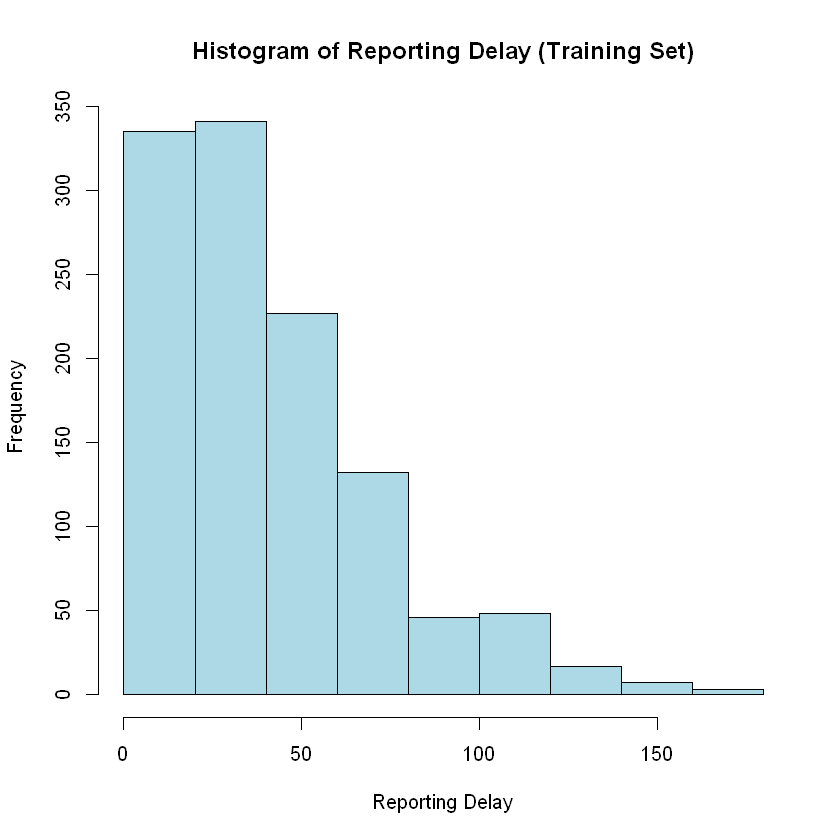

In [214]:
# Plot histogram of target_delay in the training set
summary(dt_reporting_delay_all_F[rowList_ReportDelay_F$train, target_delay])
hist(dt_reporting_delay_all_F[rowList_ReportDelay_F$train, target_delay], 
     main = "Histogram of Reporting Delay (Training Set)", 
     xlab = "Reporting Delay", 
     col = "lightblue", 
     border = "black")


In [215]:
# Hyperparameters for XGBoost model
param <- list(
  objective = "reg:squarederror",  # Regression for continuous target (reporting delay)
  max_depth = 6L,                 # Maximum depth of the trees
  subsample = 0.8,                # Fraction of rows to sample for each tree
  colsample_bytree = 0.8,         # Fraction of features to sample for each tree
  eta = 0.1,                      # Learning rate
  min_child_weight = 1            # Minimum sum of instance weight per leaf (controls overfitting)
)

# Cross-validation to find best number of rounds
set.seed(123)  # For repeatability

xgb.ReportingDelay_F_CV <- xgb.cv(
  params = param,
  data = xgb.ReportingDelay_F_DMat.train,  # DMatrix for train set
  nrounds = 2000,           # Maximum number of rounds to train
  nfold = 5,               # 5-fold cross-validation
  early_stopping_rounds = 50,  # Stop if performance doesn't improve after 50 rounds
  print_every_n = 50,      # Print progress every 50 rounds
  prediction = TRUE        # Save the predictions during CV
)

# Check the best number of rounds
best_nrounds <- xgb.ReportingDelay_F_CV$best_iteration


[1]	train-rmse:32.274762+0.495561	test-rmse:32.581469+1.733526 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 50 rounds.

[51]	train-rmse:18.357517+0.697305	test-rmse:28.631967+1.453128 
[101]	train-rmse:14.175668+0.439841	test-rmse:28.670728+1.465253 
Stopping. Best iteration:
[79]	train-rmse:15.657303+0.465717	test-rmse:28.523873+1.601770



In [216]:
# Store out-of-fold predictions in the train set
dt_reporting_delay_all_F[rowList_ReportDelay_F$train, preds_oof_reporting_delay := xgb.ReportingDelay_F_CV$pred]


In [217]:
head(dt_reporting_delay_all_F)

j,k,Cover,Brand,Model,Price,delay_uw_val,date_uw,date_pol_start_YYYYMM,flgSet,exposure,target_delay,target_count,preds_oof_reporting_delay
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,1,BO,2,0,550,269,16802,2016.01,2,1,208,1,NA
1,1,BO,2,3,837,249,16822,2016.01,1,2,155,2,52.07990
2,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,96.57033
3,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,124.07780
4,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,144.95689
5,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,146.33356


In [218]:
# Scale predictions by exposure (similar to IBNR model)
dt_reporting_delay_all_F[rowList_ReportDelay_F$train, preds_oof_reporting_delay_scaled := exposure * preds_oof_reporting_delay]


In [219]:
head(dt_reporting_delay_all_F)

j,k,Cover,Brand,Model,Price,delay_uw_val,date_uw,date_pol_start_YYYYMM,flgSet,exposure,target_delay,target_count,preds_oof_reporting_delay,preds_oof_reporting_delay_scaled
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,1,BO,2,0,550,269,16802,2016.01,2,1,208,1,NA,NA
1,1,BO,2,3,837,249,16822,2016.01,1,2,155,2,52.07990,104.15979
2,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,96.57033,96.57033
3,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,124.07780,124.07780
4,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,144.95689,144.95689
5,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,146.33356,146.33356


In [220]:
# Train the model using the best number of rounds from cross-validation
xgb.ReportingDelay_F_Fit <- xgb.train(
  params = param,  # Hyperparameters for the model
  data = xgb.ReportingDelay_F_DMat.train,  # DMatrix for train set
  nrounds = best_nrounds,  # Best number of rounds from cross-validation
  watchlist = list(train = xgb.ReportingDelay_F_DMat.train, test = xgb.ReportingDelay_F_DMat.test),  # Watch performance on train and test sets
  print_every_n = 50  # Print progress every 50 rounds
)

# Generate predictions on the full dataset (train + test)
dt_reporting_delay_all_F[rowList_ReportDelay_F$all, preds_full_reporting_delay := predict(xgb.ReportingDelay_F_Fit, xgb.ReportingDelay_F_DMat.all)]


[1]	train-rmse:32.233178	test-rmse:32.763949 
[51]	train-rmse:19.674078	test-rmse:29.417431 
[79]	train-rmse:17.789725	test-rmse:30.158099 


In [222]:
head(dt_reporting_delay_all_F)

j,k,Cover,Brand,Model,Price,delay_uw_val,date_uw,date_pol_start_YYYYMM,flgSet,exposure,target_delay,target_count,preds_oof_reporting_delay,preds_oof_reporting_delay_scaled,preds_full_reporting_delay
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,BO,2,0,550,269,16802,2016.01,2,1,208,1,NA,NA,38.83886
1,1,BO,2,3,837,249,16822,2016.01,1,2,155,2,52.07990,104.15979,107.00132
2,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,96.57033,96.57033,123.01775
3,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,124.07780,124.07780,135.37230
4,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,144.95689,144.95689,144.96960
5,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,146.33356,146.33356,145.64227


In [227]:
head(dt_reporting_delay_all_F[, .(target_delay, preds_full_reporting_delay)], 10)

target_delay,preds_full_reporting_delay
<int>,<dbl>
208,38.83886
155,107.00132
146,123.01775
146,135.37230
146,144.96960
146,145.64227
136,71.41648
136,101.04620
136,130.99684


In [228]:
# Evaluate performance by calculating the difference and percentage difference
dt_reporting_delay_all_F[rowList_ReportDelay_F$test, Diff := preds_full_reporting_delay - target_delay]
dt_reporting_delay_all_F[rowList_ReportDelay_F$test, Diff_pcnt := (Diff / target_delay) * 100]

# Print summary statistics
summary(dt_reporting_delay_all_F[rowList_ReportDelay_F$test, Diff])
summary(dt_reporting_delay_all_F[rowList_ReportDelay_F$test, Diff_pcnt])


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-169.1611  -20.3961   -0.7693   -4.3557   13.6821   78.1734 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -87.070  -35.451   -1.899   71.760   67.470 2886.147 

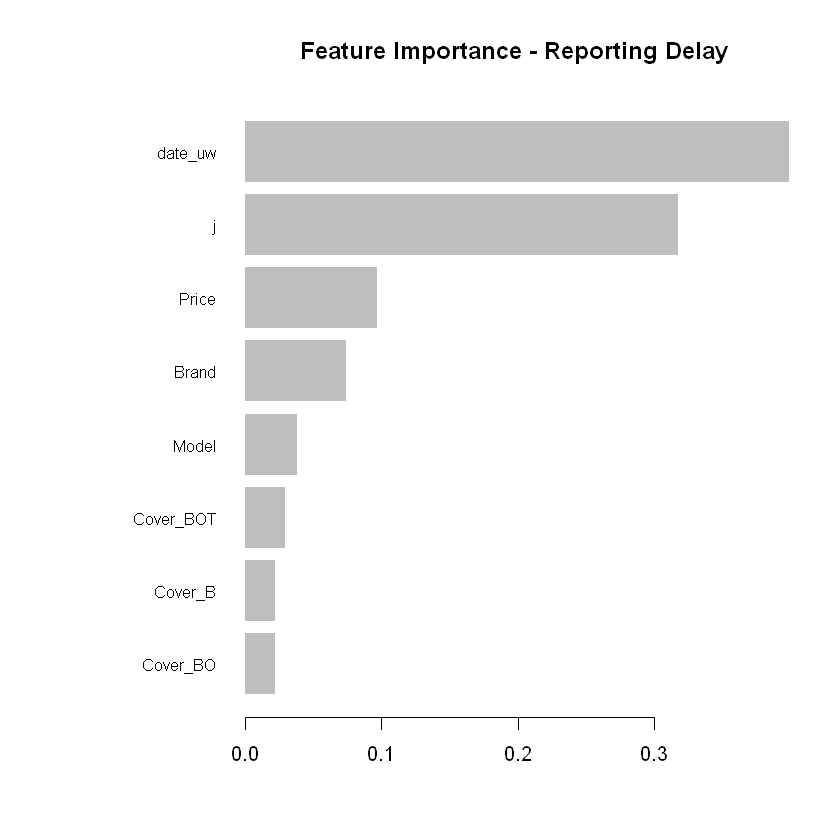

In [229]:
# Extract feature importance from the trained model
featImp_reporting_delay <- xgb.importance(model = xgb.ReportingDelay_F_Fit)

# Plot the feature importance
xgb.plot.importance(featImp_reporting_delay, main = "Feature Importance - Reporting Delay")


In [234]:
head(dt_reporting_delay_all_F)

j,k,Cover,Brand,Model,Price,delay_uw_val,date_uw,date_pol_start_YYYYMM,flgSet,exposure,target_delay,target_count,preds_oof_reporting_delay,preds_oof_reporting_delay_scaled,preds_full_reporting_delay,Diff,Diff_pcnt
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,BO,2,0,550,269,16802,2016.01,2,1,208,1,NA,NA,38.83886,-169.1611,-81.32747
1,1,BO,2,3,837,249,16822,2016.01,1,2,155,2,52.07990,104.15979,107.00132,NA,NA
2,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,96.57033,96.57033,123.01775,NA,NA
3,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,124.07780,124.07780,135.37230,NA,NA
4,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,144.95689,144.95689,144.96960,NA,NA
5,1,BO,2,3,837,249,16822,2016.01,1,1,146,1,146.33356,146.33356,145.64227,NA,NA


In [239]:
# Summarize the reporting delay predictions and targets for the test set using date_pol_start_YYYYMM
dt_reporting_delay_summary <- dt_reporting_delay_all_F[rowList_ReportDelay_F$test,
  .(
    avg_preds = mean(preds_full_reporting_delay, na.rm = TRUE),   # Average predicted delay
    avg_target = mean(target_delay, na.rm = TRUE),            # Average actual target delay
    MAE = mean(abs(preds_full_reporting_delay - target_delay), na.rm = TRUE),  # Mean Absolute Error
    RMSE = sqrt(mean((preds_full_reporting_delay - target_delay)^2, na.rm = TRUE)),  # Root Mean Squared Error
    count = .N  # Number of observations
  ),
  keyby = date_pol_start_YYYYMM  # Group by month (date_pol_start_YYYYMM)
]

# Calculate Diff and % Diff for avg delay
dt_reporting_delay_summary[, ':='(
  Diff = (avg_preds - avg_target),  # Difference between predicted and actual delay
  Diff_pcnt = scales::percent((avg_preds - avg_target) / avg_target, accuracy = 0.1)  # Percentage difference
)]

# Show the first few rows of the summarized table
head(dt_reporting_delay_summary, 15)


date_pol_start_YYYYMM,avg_preds,avg_target,MAE,RMSE,count,Diff,Diff_pcnt
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
2016.01,49.50623,47.26543,25.94814,35.07458,162,2.2407934,4.7%
2016.02,44.64895,48.47273,20.54842,26.47041,165,-3.8237808,-7.9%
2016.03,45.10712,44.52027,20.92354,26.42786,148,0.5868494,1.3%
2016.04,44.51089,49.62252,22.81834,29.80481,151,-5.1116305,-10.3%
2016.05,43.87881,50.03867,24.29031,33.11544,181,-6.1598683,-12.3%
2016.06,43.74379,45.45294,21.70017,28.76285,170,-1.7091467,-3.8%
2016.07,37.80636,44.89937,19.42861,24.71522,159,-7.0930144,-15.8%
2016.08,28.82198,42.62987,17.86653,22.86526,154,-13.8078925,-32.4%
2016.09,24.13133,28.59649,10.62317,13.12825,57,-4.4651599,-15.6%


In [244]:
head(dt_payment_delay_all)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,...,Price,payment_delay,flgSet,Count,delay_uw_occ,delay_occ_rep,delay_rep_pay,delay_uw_val,date_uw,date_occur_YYYYMM
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,...,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
201602190014,201602080485,1,1,1,2016-02-08,2016-02-19,2016-08-11,2016-09-15,BO,...,794,35,3,1,11,174,35,232,16839,2016.02
201603030014,201602150415,1,1,1,2016-02-15,2016-03-03,2016-07-29,2016-08-30,BO,...,913,32,3,1,17,148,32,225,16846,2016.03
201604090031,201602290519,1,1,1,2016-02-29,2016-04-09,2016-08-11,2016-09-13,BO,...,199,33,3,1,40,124,33,211,16860,2016.04
201604140015,201601280407,1,1,1,2016-01-28,2016-04-14,2016-08-15,2016-09-10,BO,...,397,26,3,1,77,123,26,243,16828,2016.04
201604150013,201601270218,1,1,1,2016-01-27,2016-04-15,2016-08-11,2016-09-09,BOT,...,728,29,3,1,79,118,29,244,16827,2016.04
201604150056,201604130247,1,1,1,2016-04-13,2016-04-15,2016-08-03,2016-09-03,BOT,...,457,31,3,1,2,110,31,167,16904,2016.04


In [280]:
# Define the predictors for Payment Delay model
payment_delay_predictors <- c(
  "j",                 # Development period (adjust as needed)
  "k",                 # Development period (adjust as needed)
  "Cover",             # Type of cover (e.g., B, BO, BOT)
  "Brand",             # Brand of the product
  "Model",             # Model of the product
  "Price",             # Price of the product
  "delay_uw_val",      # Delay from underwriting or other relevant field
  "date_uw"            # Underwriting date
)

# Format the occurrence date to year-month
dt_payment_delay_all[, date_occur_YYYYMM := as.character(year(date_occur) + month(date_occur)/100)]
dt_payment_delay_all[, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100)]


# Aggregate the data for Payment Delay model
dt_payment_delay_all_F <- dt_payment_delay_all[, .(exposure = sum(payment_delay > 0),
                                                    target_delay_sum = sum(payment_delay)),
                                               by = c(payment_delay_predictors, "date_occur_YYYYMM", "flgSet")]

# Filter out rows with zero exposure
dt_payment_delay_all_F <- dt_payment_delay_all_F[exposure > 0]

# Setup train, test, and all datasets for XGBoost
rowList_Payment_Delay <- list(
  train = dt_payment_delay_all_F[, which(flgSet == 3)],  # Train set (flgSet == 3)
  test = dt_payment_delay_all_F[, which(flgSet == 4)],   # Test set (flgSet == 4)
  all = dt_payment_delay_all_F[, which(flgSet %in% c(3, 4))]  # All data (train and test)
)

# Setup data for XGBoost
payment_delay_rec <- recipe( ~ ., data = dt_payment_delay_all_F[, payment_delay_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.Payment_Delay_train <- bake(payment_delay_rec, new_data = dt_payment_delay_all_F[rowList_Payment_Delay$train,])
df.Payment_Delay_test <- bake(payment_delay_rec, new_data = dt_payment_delay_all_F[rowList_Payment_Delay$test,])
df.Payment_Delay_all <- bake(payment_delay_rec, new_data = dt_payment_delay_all_F[rowList_Payment_Delay$all,])

# Create DMatrix for XGBoost


In [281]:
head(df.Payment_Delay_train)
str(df.Payment_Delay_train)

j,k,Brand,Model,Price,delay_uw_val,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2,794,232,16839,0,1,0
1,1,1,3,913,225,16846,0,1,0
1,1,4,2,199,211,16860,0,1,0
1,1,3,2,397,243,16828,0,1,0
1,1,2,2,728,244,16827,0,0,1
1,1,3,3,457,167,16904,0,0,1


tibble [2,307 x 10] (S3: tbl_df/tbl/data.frame)
 $ j           : int [1:2307] 1 1 1 1 1 1 1 1 1 1 ...
 $ k           : int [1:2307] 1 1 1 1 1 1 1 1 1 1 ...
 $ Brand       : num [1:2307] 1 1 4 3 2 3 1 2 1 3 ...
 $ Model       : num [1:2307] 2 3 2 2 2 3 2 3 3 2 ...
 $ Price       : num [1:2307] 794 913 199 397 728 457 794 837 913 397 ...
 $ delay_uw_val: num [1:2307] 232 225 211 243 244 167 237 238 183 249 ...
 $ date_uw     : num [1:2307] 16839 16846 16860 16828 16827 ...
 $ Cover_B     : num [1:2307] 0 0 0 0 0 0 0 1 1 0 ...
  ..- attr(*, "assign")= int [1:3] 1 1 1
  ..- attr(*, "contrasts")=List of 1
  .. ..$ Cover: chr "contr.treatment"
 $ Cover_BO    : num [1:2307] 1 1 1 1 0 0 0 0 0 1 ...
  ..- attr(*, "assign")= int [1:3] 1 1 1
  ..- attr(*, "contrasts")=List of 1
  .. ..$ Cover: chr "contr.treatment"
 $ Cover_BOT   : num [1:2307] 0 0 0 0 1 1 1 0 0 0 ...
  ..- attr(*, "assign")= int [1:3] 1 1 1
  ..- attr(*, "contrasts")=List of 1
  .. ..$ Cover: chr "contr.treatment"


In [282]:
head(df.Payment_Delay_test)

j,k,Brand,Model,Price,delay_uw_val,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,3,837,249,16822,0,1,0
1,1,2,1,633,221,16850,0,1,0
1,1,1,2,794,227,16844,0,1,0
1,1,2,1,633,204,16867,0,0,1
1,1,1,2,794,256,16815,0,0,1
1,1,1,2,794,193,16878,0,0,1


In [283]:
head(df.Payment_Delay_all)

j,k,Brand,Model,Price,delay_uw_val,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2,794,232,16839,0,1,0
1,1,1,3,913,225,16846,0,1,0
1,1,4,2,199,211,16860,0,1,0
1,1,3,2,397,243,16828,0,1,0
1,1,2,2,728,244,16827,0,0,1
1,1,3,3,457,167,16904,0,0,1


In [284]:
# Check the structure of df.Payment_Delay_train to identify non-numeric columns
str(df.Payment_Delay_train)

# Select only the numeric columns for XGBoost
df.Payment_Delay_train_numeric <- df.Payment_Delay_train[, sapply(df.Payment_Delay_train, is.numeric), with = FALSE]

# Convert the data to a numeric matrix (ensure that no non-numeric columns are included)
df.Payment_Delay_train_matrix <- as.matrix(df.Payment_Delay_train_numeric)

# Ensure the matrix is numeric
if (!is.numeric(df.Payment_Delay_train_matrix)) {
  stop("The training data is not numeric!")
}

# Create the DMatrix for XGBoost with the proper data type
xgb.Payment_Delay_DMat.train <- xgb.DMatrix(
  data = df.Payment_Delay_train_matrix,  # Numeric matrix of predictors
  weight = dt_payment_delay_all_F[rowList_Payment_Delay$train, exposure],  # Weight based on exposure
  label = dt_payment_delay_all_F[rowList_Payment_Delay$train, target_delay_sum]  # Label is the target_delay_sum
)


tibble [2,307 x 10] (S3: tbl_df/tbl/data.frame)
 $ j           : int [1:2307] 1 1 1 1 1 1 1 1 1 1 ...
 $ k           : int [1:2307] 1 1 1 1 1 1 1 1 1 1 ...
 $ Brand       : num [1:2307] 1 1 4 3 2 3 1 2 1 3 ...
 $ Model       : num [1:2307] 2 3 2 2 2 3 2 3 3 2 ...
 $ Price       : num [1:2307] 794 913 199 397 728 457 794 837 913 397 ...
 $ delay_uw_val: num [1:2307] 232 225 211 243 244 167 237 238 183 249 ...
 $ date_uw     : num [1:2307] 16839 16846 16860 16828 16827 ...
 $ Cover_B     : num [1:2307] 0 0 0 0 0 0 0 1 1 0 ...
  ..- attr(*, "assign")= int [1:3] 1 1 1
  ..- attr(*, "contrasts")=List of 1
  .. ..$ Cover: chr "contr.treatment"
 $ Cover_BO    : num [1:2307] 1 1 1 1 0 0 0 0 0 1 ...
  ..- attr(*, "assign")= int [1:3] 1 1 1
  ..- attr(*, "contrasts")=List of 1
  .. ..$ Cover: chr "contr.treatment"
 $ Cover_BOT   : num [1:2307] 0 0 0 0 1 1 1 0 0 0 ...
  ..- attr(*, "assign")= int [1:3] 1 1 1
  ..- attr(*, "contrasts")=List of 1
  .. ..$ Cover: chr "contr.treatment"


In [285]:
xgb.Payment_Delay_DMat.train <- xgb.DMatrix(data = as.matrix(df.Payment_Delay_train),
                                            weight = dt_payment_delay_all_F[rowList_Payment_Delay$train, exposure],
                                            label = dt_payment_delay_all_F[rowList_Payment_Delay$train, target_delay_sum])

xgb.Payment_Delay_DMat.test <- xgb.DMatrix(data = as.matrix(df.Payment_Delay_test),
                                           weight = dt_payment_delay_all_F[rowList_Payment_Delay$test, exposure],
                                           label = dt_payment_delay_all_F[rowList_Payment_Delay$test, target_delay_sum])

xgb.Payment_Delay_DMat.all <- xgb.DMatrix(data = as.matrix(df.Payment_Delay_all),
                                          weight = dt_payment_delay_all_F[rowList_Payment_Delay$all, exposure],
                                          label = dt_payment_delay_all_F[rowList_Payment_Delay$all, target_delay_sum])


In [286]:
# Summary of the target_delay_sum for the training set
summary(dt_payment_delay_all_F[rowList_Payment_Delay$train, target_delay_sum])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.00   28.00   32.00   34.44   36.00  136.00 

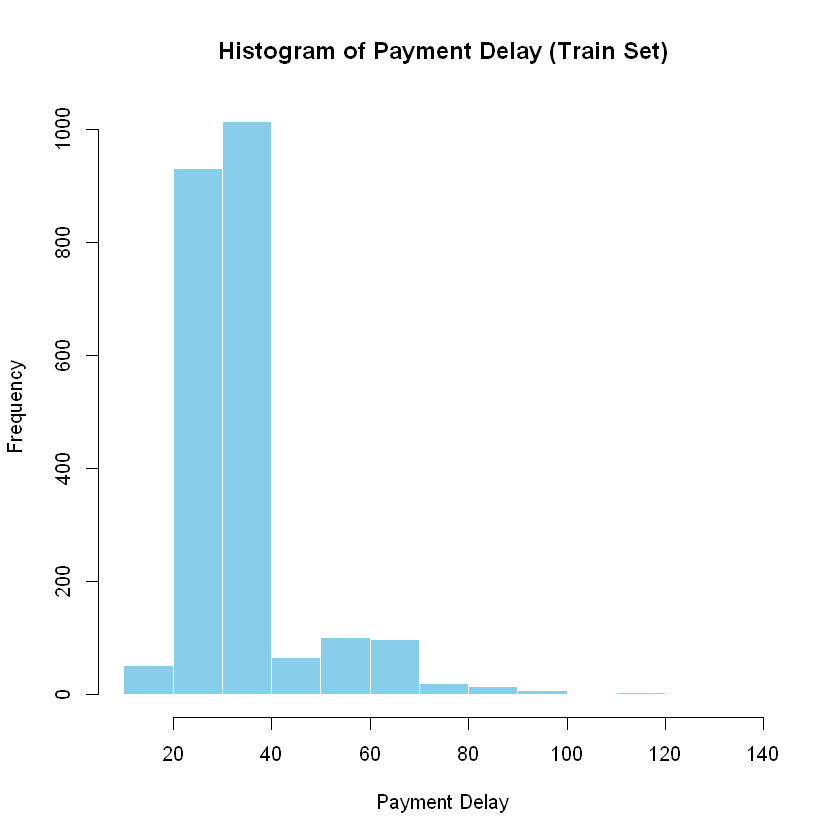

In [287]:
# Histogram of the target_delay_sum for the training set
hist(dt_payment_delay_all_F[rowList_Payment_Delay$train, target_delay_sum], 
     main = "Histogram of Payment Delay (Train Set)",
     xlab = "Payment Delay",
     col = "skyblue", 
     border = "white")


In [288]:
# Set hyperparameters for XGBoost model for Payment Delay
param <- list(
  objective = "reg:squarederror",  # Regression for continuous target (payment delay)
  max_depth = 6L,                 # Maximum depth of the trees
  subsample = 0.8,                # Fraction of rows to sample for each tree
  colsample_bytree = 0.8,         # Fraction of features to sample for each tree
  eta = 0.1,                      # Learning rate
  min_child_weight = 1            # Minimum sum of instance weight per leaf (controls overfitting)
)

# Cross-validation to find best number of rounds for Payment Delay model
set.seed(123)  # For repeatability

xgb.PaymentDelay_F_CV <- xgb.cv(
  params = param,
  data = xgb.Payment_Delay_DMat.train,  # DMatrix for train set
  nrounds = 2000,           # Maximum number of rounds to train
  nfold = 5,                # 5-fold cross-validation
  early_stopping_rounds = 50,  # Stop if performance doesn't improve after 50 rounds
  print_every_n = 50,      # Print progress every 50 rounds
  prediction = TRUE        # Save the predictions during CV
)

# Check the best number of rounds
best_nrounds_payment_delay <- xgb.PaymentDelay_F_CV$best_iteration


[1]	train-rmse:16.223986+0.324907	test-rmse:16.427136+1.391390 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 50 rounds.

[51]	train-rmse:11.163978+0.257088	test-rmse:16.194474+1.217201 
Stopping. Best iteration:
[17]	train-rmse:13.219493+0.311006	test-rmse:15.800160+1.247923



In [289]:
# Store the out-of-fold predictions for the train set
dt_payment_delay_all_F[rowList_Payment_Delay$train, preds_oof_PaymentDelay := xgb.PaymentDelay_F_CV$pred]

# Multiply the predictions by exposure to get the weighted predictions
dt_payment_delay_all_F[rowList_Payment_Delay$train, preds_oof_PaymentDelay_Weighted := exposure * preds_oof_PaymentDelay]


In [290]:
head(dt_payment_delay_all_F)

j,k,Cover,Brand,Model,Price,delay_uw_val,date_uw,date_occur_YYYYMM,flgSet,exposure,target_delay_sum,preds_oof_PaymentDelay,preds_oof_PaymentDelay_Weighted
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,1,BO,1,2,794,232,16839,2016.02,3,1,35,55.72214,55.72214
1,1,BO,1,3,913,225,16846,2016.03,3,1,32,43.73399,43.73399
1,1,BO,4,2,199,211,16860,2016.04,3,1,33,35.51548,35.51548
1,1,BO,3,2,397,243,16828,2016.04,3,1,26,34.50753,34.50753
1,1,BOT,2,2,728,244,16827,2016.04,3,1,29,34.49866,34.49866
1,1,BOT,3,3,457,167,16904,2016.04,3,1,31,33.16668,33.16668


In [291]:
# Train the final model using the best number of rounds from cross-validation
xgb.PaymentDelay_F_Fit <- xgb.train(
  params = param,  # Hyperparameters for the model
  data = xgb.Payment_Delay_DMat.train,  # DMatrix for train set
  nrounds = best_nrounds_payment_delay,  # Best number of rounds from cross-validation
  watchlist = list(train = xgb.Payment_Delay_DMat.train, test = xgb.Payment_Delay_DMat.test),  # Watch performance on train and test sets
  print_every_n = 50  # Print progress every 50 rounds
)

# Store the predictions for the 'all' dataset
dt_payment_delay_all_F[rowList_Payment_Delay$all, preds_full_PaymentDelay := predict(xgb.PaymentDelay_F_Fit, xgb.Payment_Delay_DMat.all)]


[1]	train-rmse:16.192648	test-rmse:15.019667 
[17]	train-rmse:13.384141	test-rmse:15.019080 


In [292]:
head(dt_payment_delay_all_F)

j,k,Cover,Brand,Model,Price,delay_uw_val,date_uw,date_occur_YYYYMM,flgSet,exposure,target_delay_sum,preds_oof_PaymentDelay,preds_oof_PaymentDelay_Weighted,preds_full_PaymentDelay
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,BO,1,2,794,232,16839,2016.02,3,1,35,55.72214,55.72214,51.50059
1,1,BO,1,3,913,225,16846,2016.03,3,1,32,43.73399,43.73399,42.40193
1,1,BO,4,2,199,211,16860,2016.04,3,1,33,35.51548,35.51548,35.15765
1,1,BO,3,2,397,243,16828,2016.04,3,1,26,34.50753,34.50753,35.18293
1,1,BOT,2,2,728,244,16827,2016.04,3,1,29,34.49866,34.49866,35.58997
1,1,BOT,3,3,457,167,16904,2016.04,3,1,31,33.16668,33.16668,35.08879


In [293]:
head(dt_payment_delay_all_F[, .(target_delay_sum, preds_full_PaymentDelay)], 10)

target_delay_sum,preds_full_PaymentDelay
<int>,<dbl>
35,51.50059
32,42.40193
33,35.15765
26,35.18293
29,35.58997
31,35.08879
27,39.73269
24,37.67533
29,32.66422


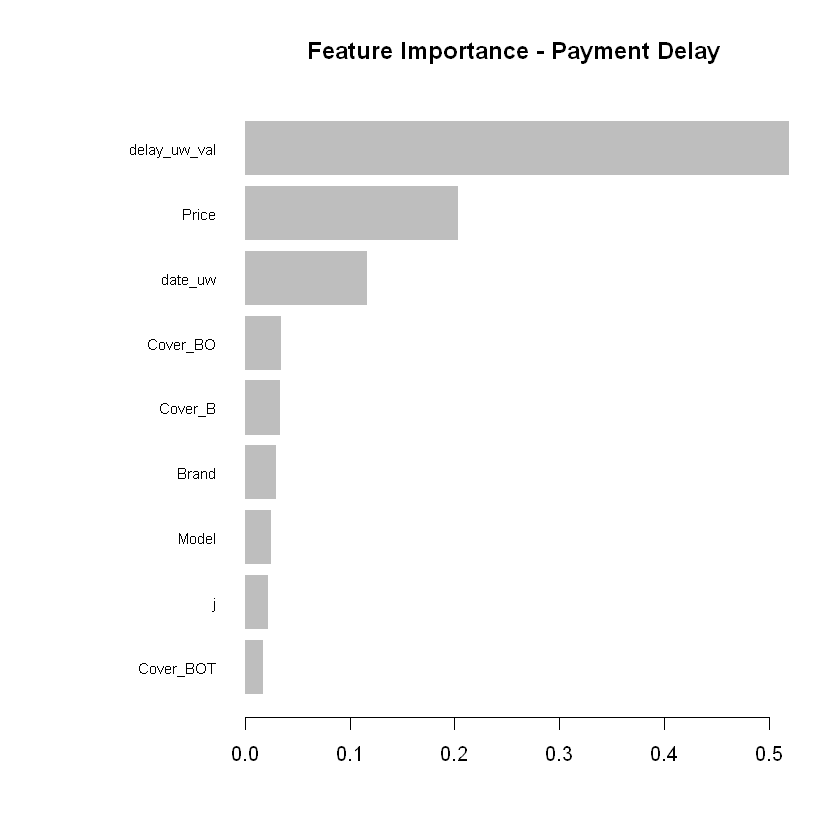

In [294]:
# Default feature importance by gain
featImp_PaymentDelay <- xgb.importance(
  model = xgb.PaymentDelay_F_Fit, 
  feature_names = colnames(xgb.Payment_Delay_DMat.train)
)

# Plot the feature importance
xgb.plot.importance(
  featImp_PaymentDelay, 
  main = "Feature Importance - Payment Delay"
)


In [295]:
# Summarize the payment delay predictions and targets for the test set, grouped by occurrence month (date_occur_YYYYMM)
dt_payment_delay_summary <- dt_payment_delay_all_F[rowList_Payment_Delay$test,
  .(
    avg_preds = mean(preds_full_PaymentDelay, na.rm = TRUE),   # Average predicted delay
    avg_target = mean(target_delay_sum, na.rm = TRUE),         # Average actual target delay
    MAE = mean(abs(preds_full_PaymentDelay - target_delay_sum), na.rm = TRUE),  # Mean Absolute Error
    RMSE = sqrt(mean((preds_full_PaymentDelay - target_delay_sum)^2, na.rm = TRUE)),  # Root Mean Squared Error
    count = .N  # Number of observations
  ),
  keyby = date_occur_YYYYMM  # Group by occurrence month (date_occur_YYYYMM)
]

# Calculate Diff and % Diff for avg delay
dt_payment_delay_summary[, ':='(
  Diff = (avg_preds - avg_target),  # Difference between predicted and actual delay
  Diff_pcnt = scales::percent((avg_preds - avg_target) / avg_target, accuracy = 0.1)  # Percentage difference
)]

# Show the first few rows of the summarized table
head(dt_payment_delay_summary, 15)


date_occur_YYYYMM,avg_preds,avg_target,MAE,RMSE,count,Diff,Diff_pcnt
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
2016.04,36.19846,28.00000,8.198458,9.368778,2,8.198458,29.3%
2016.05,37.79565,34.60000,4.563029,5.697694,10,3.195648,9.2%
2016.06,37.04943,32.18182,6.370793,7.569308,33,4.867615,15.1%
2016.07,37.36594,32.38068,8.370438,10.559399,176,4.985261,15.4%
2016.08,36.81675,34.08246,8.179246,11.466482,958,2.734282,8.0%
2016.09,36.45621,33.63608,9.186205,12.645608,1624,2.820126,8.4%


In [296]:
# Summarize the payment delay predictions and targets for the test set, grouped by policy start month (date_pol_start_YYYYMM)
dt_payment_delay_summary_polstart <- dt_payment_delay_all_F[rowList_Payment_Delay$test,
  .(
    avg_preds = mean(preds_full_PaymentDelay, na.rm = TRUE),   # Average predicted delay
    avg_target = mean(target_delay_sum, na.rm = TRUE),         # Average actual target delay
    MAE = mean(abs(preds_full_PaymentDelay - target_delay_sum), na.rm = TRUE),  # Mean Absolute Error
    RMSE = sqrt(mean((preds_full_PaymentDelay - target_delay_sum)^2, na.rm = TRUE)),  # Root Mean Squared Error
    count = .N  # Number of observations
  ),
  keyby = date_pol_start_YYYYMM  # Group by policy start month (date_pol_start_YYYYMM)
]

# Calculate Diff and % Diff for avg delay
dt_payment_delay_summary_polstart[, ':='(
  Diff = (avg_preds - avg_target),  # Difference between predicted and actual delay
  Diff_pcnt = scales::percent((avg_preds - avg_target) / avg_target, accuracy = 0.1)  # Percentage difference
)]

# Show the first few rows of the summarized table
head(dt_payment_delay_summary_polstart, 15)


ERROR: Error in eval(bysub, parent.frame(), parent.frame()): object 'date_pol_start_YYYYMM' not found
